Turbocharged demo
==

We demonstrate the rough Bergomi (rBergomi) price process introduced by [Bayer, Friz and Gatheral](https://ssrn.com/abstract=2554754), which we define here by

$$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2, $$

$$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}, \quad Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u,$$

for Brownian motion $(W^1, W^2)$. The *hybrid scheme* of [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004) is used for efficient, $\mathcal{O}(n\log n)$, simulation of the Volterra process, $Y_t^a$.

From $N$ samples of the price process, $\{S^i_t\}_{i = 1}^N$ , we show implied volatilities, $\hat{\sigma}^N_{BS}(k,t)$,  using estimators of the form

$$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N (X_i + c Y_i) - c\mathbb{E}[Y],$$

as described in [McCrickerd and Pakkanen](https://arxiv.org/abs/1708.02563). For simplicity, we just use call option estimators (rather than OTM option estimators) and do not use antithetic sampling here.

We thus define a Base estimator here by $$X = \max(S_t - e^k,0),\quad Y = 0$$ and a Mixed estimator by $$X = BS\left((1 - \rho^2)\int_0^t V_u\mathrm{d}u; S^1_t,k\right),\quad Y = BS\left(\rho^2\left(Q - \int_0^t V_u\mathrm{d}u\right); S^1_t,k\right)$$

where $S^1_t$ is the parallel component of the price process, defined by $$S^1_t := \exp \left\{ \rho\int_0^t \sqrt{ V_u } \mathrm{d}W^1_u - \frac{\rho^2}{2}\int_0^t V_u \mathrm{d}u \right\}.$$

While most computations are hidden in the methods of the rBergomi class, we expose the Mixed estimator calculations in this notebook for transparency.

Change directory to folder with rBergomi scripts

In [31]:
import os
os.chdir('D:/pyfops/')
import time; time_start = time.time()

Import required libraries, classes and functions

In [32]:
import numpy as np
from matplotlib import pyplot as plt
import src.core.forecasting.rough_bergomi.np_rbergomi_func as rB
vec_bsinv = np.vectorize(rB.bsinv)
#% matplotlib inline

Create instance of the rBergomi class with $n$ steps per year, $N$ paths, maximum maturity $T$ and roughness index $a$

In [33]:
n = 365
N = 50000
T = 0.25
H = 0.07
rho = -0.9
xi = 0.235**2
eta = 1.9

a = H-0.5
dt = 1./n
s = int(n*T)
t=np.linspace(0, T, 1+s)[np.newaxis, :]

e = np.array([0,0])
c = rB.cov(a, n)

Fix the generator's seed for replicable results

In [34]:
np.random.seed(0)

Generate required Brownian increments

In [35]:
time_=time.time()
dW1 = rB.dW1(e, c, N, s)
dW2 = rB.dW2(N, s, dt)
print(time.time()-time_)

0.43097710609436035


Construct the Volterra process, $$Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u$$

In [36]:
Ya = rB.Y(N, s, n, a, dW1)
print(time.time()-time_)

0.9431581497192383


Correlate the orthogonal increments, using $\rho$, $$B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2$$

In [37]:
dB = rB.dB(dW1, dW2, rho)
print(time.time()-time_)

0.9919168949127197


Construct the variance process, using $\xi$ and $\eta$, $$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}$$

In [38]:
V = rB.V(Ya, xi, eta, t, a) 
print(time.time()-time_)

1.0850741863250732


Finally construct the price processes, $$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad S^1_t := \exp \left\{ \rho\int_0^t \sqrt{ V_u } \mathrm{d}W^1_u - \frac{\rho^2}{2}\int_0^t V_u \mathrm{d}u \right\}$$

In [39]:
S = rB.S(V, dB, 1., dt)
S1 = rB.S1(V, dW1, rho, 1., dt)
print(time.time()-time_)

1.3615789413452148


Now set log-strikes, $k$

In [40]:
k = np.array([-0.1787,0.0000,0.1041])
K = np.exp(k)[np.newaxis,:]

and known implied volatilities for this model specification

In [41]:
implied_vols = np.array([0.2961,0.2061,0.1576])[:,np.newaxis]

Compute Base call payoffs, prices, and estimated volatilities,

In [42]:
ST = S[:,-1][:,np.newaxis]
print((1.96*np.std(ST, axis=0)/0.001)**2)
base_payoffs = np.maximum(ST - K,0)
base_prices = np.mean(base_payoffs, axis = 0)[:,np.newaxis]
base_vols = vec_bsinv(base_prices, 1., np.transpose(K), T)
print(base_vols)

[46223.52399559]
[[0.2945162 ]
 [0.20551614]
 [0.16084703]]


Do the same for the Mixed estimator, including the quadratic variation, $\mathrm{QV} = \int_0^t V_u \mathrm{d}u$, and variation budget, $\mathrm{Q}$

In [43]:
QV = np.sum(V, axis = 1)[:,np.newaxis] * dt
Q = np.max(QV) + 1e-9 
print(Q)

0.6392803756892638


$$X = BS\left((1 - \rho^2)\int_0^t V_u\mathrm{d}u; S^1_t,k\right),\quad Y = BS\left(\rho^2\left(Q - \int_0^t V_u\mathrm{d}u\right); S^1_t,k\right)$$

In [44]:
S1T = S1[:,-1][:,np.newaxis]
print((1.96*np.std(S1T, axis=0)/0.001)**2)
X = rB.bs(S1T, K, (1 - rho**2) * QV)
Y = rB.bs(S1T, K, rho**2 * (Q - QV))
eY = rB.bs(1., K, rho**2 * Q)

# Asymptotically optimal weights
c = np.zeros_like(k)[np.newaxis,:]
for i in range(len(k)):
    cov_mat = np.cov(X[:,i], Y[:,i])
    c[0,i] = - cov_mat[0,1] / cov_mat[1,1]
print(X.shape, c.shape, Y.shape, eY.shape)
# Payoffs, prices and volatilities
mixed_payoffs = X + c * (Y - eY)
mixed_prices = np.mean(mixed_payoffs, axis = 0)[:,np.newaxis]
mixed_vols = vec_bsinv(mixed_prices, 1., np.transpose(K), T)
print(mixed_vols)

[37058.90986419]
(50000, 3) (1, 3) (50000, 3) (1, 3)
[[0.29477556]
 [0.2057363 ]
 [0.16078472]]


Now plot implied volatilities against Base and Mixed estimators

Runtime: 1.58 seconds with 50000 paths

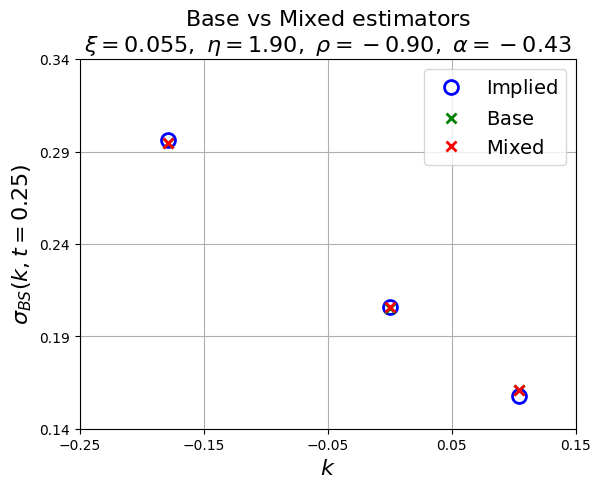

In [45]:
import time
plot,axes = plt.subplots()
# Add Implied, Base and Mixed vols
axes.plot(k, implied_vols, 'bo', fillstyle = 'none', ms = 10, mew = 2)
axes.plot(k, base_vols, 'gx', ms = 7, mew = 2)
axes.plot(k, mixed_vols, 'rx', ms = 7, mew = 2)
# Label figure
axes.set_xlabel(r'$k$',fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%T,fontsize=16)
title1 = r'$\mathrm{Base\ vs\ Mixed\ estimators}$'
title2 = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title1+'\n'+title2%(xi,eta,rho,a), fontsize=16)
axes.legend([r'$\mathrm{Implied}$',r'$\mathrm{Base}$',r'$\mathrm{Mixed}$'], fontsize=14)
# Set scale to match paper
set_scale = True
if set_scale:
    xmin,xmax = -0.25,0.15
    ymin,ymax =  0.14,0.34
    nticks = 5
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    axes.xaxis.set_ticks(np.linspace(xmin,xmax,nticks))
    axes.yaxis.set_ticks(np.linspace(ymin,ymax,nticks))
plt.grid(True)
print(f"Runtime: {(time.time() - time_start):.2f} seconds with {N} paths")

Please do not attempt to draw conclusions regarding the relative performance of the Base and Mixed estimators from just one (or several) simulation(s) / seed(s) !